 Effectuer les différents imports

In [17]:
import torch
import numpy as np
from joblib import load
from tqdm import tqdm
from data.solarSystemDataSet import SolarSystemDataset
import matplotlib.pyplot as plt
import pandas as pd

Configurations

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LEN = 15          # Doit être identique à celui de l'entraînement
DAYS_TO_PREDICT = 365
MODEL_PATH = "model_lstm.pth"
SCALER_PATH = "model_25-11-25/scaler.joblib"
DATA_PATH = "data/body_coordinates_and_velocities_from_1749-12-31_to_2200-01-09.json"

Chargement des ressources

In [19]:
print("Chargement des données et du modèle...")
scaler = load(SCALER_PATH)
df_all = pd.read_json(DATA_PATH, lines=True)

df_2025 = df_all[df_all["datetime_str"].str.startswith("A.D. 2025-")].copy()
df_2025['body_mass'] = np.log10(df_2025['body_mass'])
temp_dataset = SolarSystemDataset(df_2025, scaler)

# Initialisation du Modèle
sample_state = temp_dataset.states[0]
num_bodies = sample_state.shape[0]

model = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
model.eval()
print("Modèle chargé.")

current_sequence = [temp_dataset.states[i].to(DEVICE) for i in range(SEQ_LEN)]
predictions = []
print(f"Lancement de la prédiction (Mode Delta) sur {DAYS_TO_PREDICT} jours...")

with torch.no_grad():
    for day_idx in tqdm(range(DAYS_TO_PREDICT)):
        # A. Entrée
        input_tensor = torch.stack(current_sequence).unsqueeze(0)

        # B. Prédiction du DELTA (Mouvement)
        pred_delta_norm = model(input_tensor) # (1, 9, 6)

        # C. Mise à jour : Nouvel État = Ancien État + Delta Prédit
        last_state = current_sequence[-1] # (9, 7)

        # On prépare le delta complet (avec 0 pour la masse)
        delta_phys = pred_delta_norm.squeeze(0)
        zeros_mass = torch.zeros(delta_phys.shape[0], 1).to(DEVICE)
        delta_full = torch.cat([delta_phys, zeros_mass], dim=1)

        # ADDITION du mouvement (C'est ici que ça change !)
        new_state = last_state + delta_full

        # D. Glissement
        current_sequence.pop(0)
        current_sequence.append(new_state)

        # E. Sauvegarde
        state_np = new_state.cpu().numpy()
        state_real = scaler.inverse_transform(state_np)

        df_day = pd.DataFrame(state_real, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'body_mass'])
        df_day['day'] = day_idx
        body_ids = df_2025.sort_values(['datetime_jd', 'body_id'])['body_id'].unique()
        df_day['body_id'] = body_ids

        predictions.append(df_day)

Chargement des données et du modèle...


C:\Users\yoanl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Processing data groups: 100%|██████████| 365/365 [00:00<00:00, 4778.81it/s]


Modèle chargé.
Lancement de la prédiction (Mode Delta) sur 365 jours...


100%|██████████| 365/365 [00:00<00:00, 781.45it/s]


Sauvegarde JSON

In [20]:
df_pred_final = pd.concat(predictions, ignore_index=True)
output_file = "predicted_lstm_2025.json"
df_pred_final.to_json(output_file, orient='records', lines=True)
print(f"Prédictions terminées et sauvegardées dans {output_file}")

Prédictions terminées et sauvegardées dans predicted_lstm_2025.json


VISUALISATION

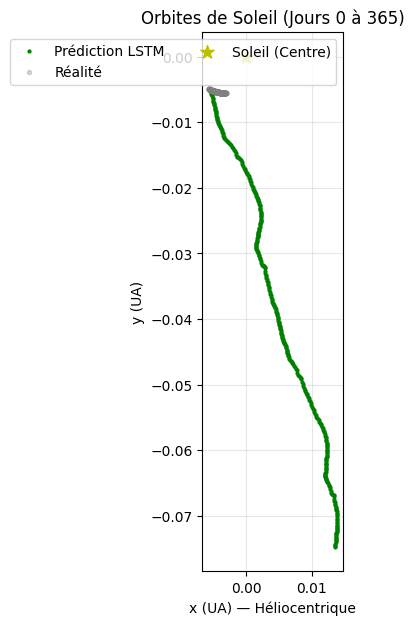

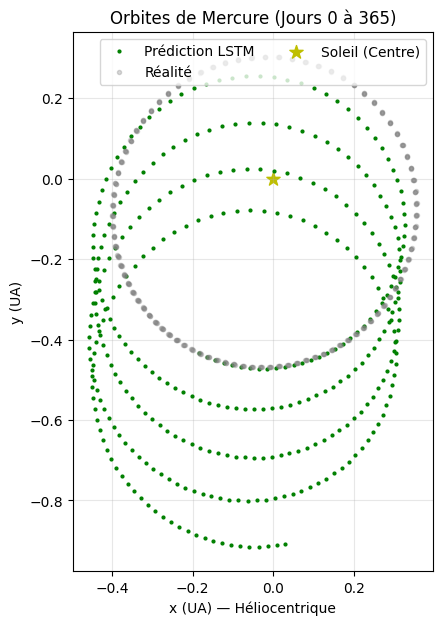

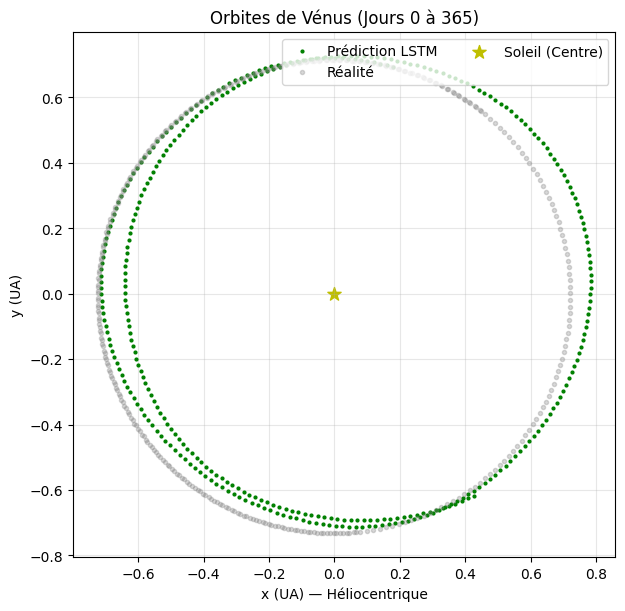

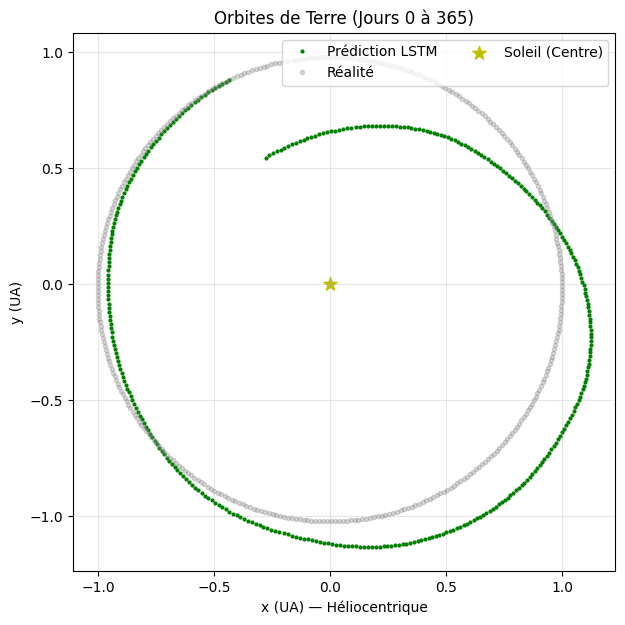

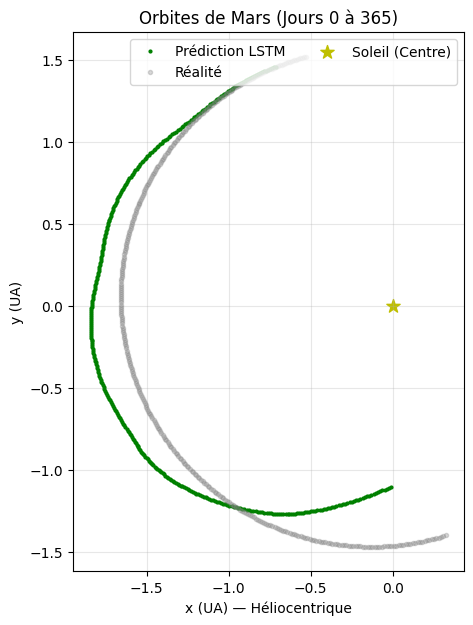

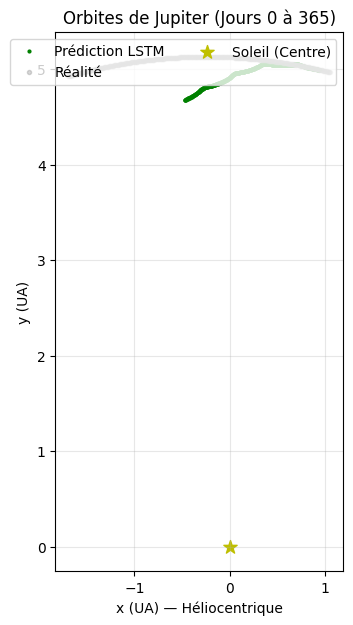

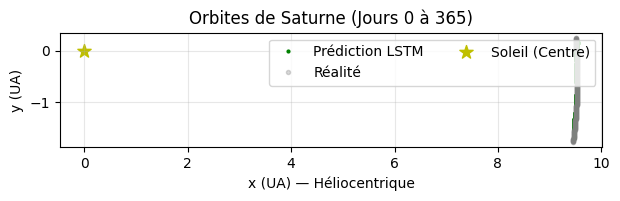

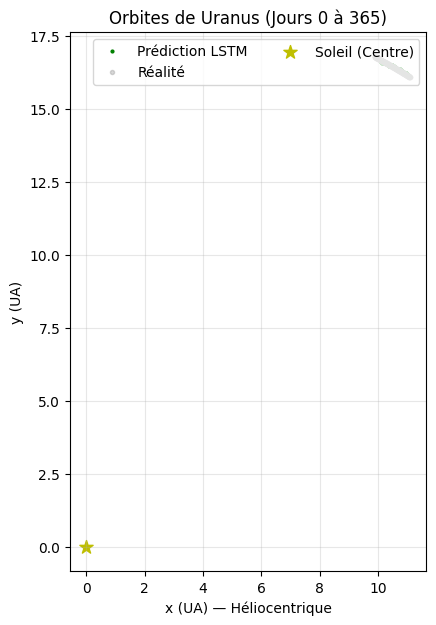

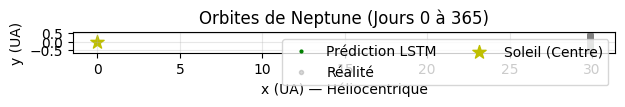

In [22]:


df_pred_lstm = pd.read_json("predicted_lstm_2025.json", lines=True)

planet_map = {
    10: "Soleil", 199: "Mercure", 299: "Vénus", 399: "Terre",
    499: "Mars", 599: "Jupiter", 699: "Saturne", 799: "Uranus", 899: "Neptune"
}

num_days = 365

for bid, name in planet_map.items():

    df_planet_pred = df_pred_lstm[
        (df_pred_lstm["body_id"] == bid) &
        (df_pred_lstm["day"] < num_days)
    ]

    df_planet_target = df_2025[
        (df_2025["body_id"] == bid)
    ].sort_values("datetime_jd").head(num_days)

    if df_planet_pred.empty:
        continue

    fig, ax = plt.subplots(figsize=(7, 7))

    ax.plot(df_planet_pred["x"], df_planet_pred["y"], ".g", label="Prédiction LSTM", markersize=4)

    ax.plot(df_planet_target["x"], df_planet_target["y"], marker=".", ls="None", color="gray", label="Réalité", alpha=0.3)

    ax.scatter([0], [0], marker="*", s=100, label="Soleil (Centre)", color="y")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (UA) — Héliocentrique")
    ax.set_ylabel("y (UA)")
    ax.set_title(f"Orbites de {name} (Jours 0 à {num_days})")
    ax.grid(True, alpha=0.3)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol=2, loc='upper right')

    plt.show()